In [1]:
from rdkit import Chem
import numpy as np
np.random.seed(123)  # for reproducibility
import matplotlib.pyplot as plt
import matplotlib
from keras import Input
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Softmax, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import tensorflow as tf

In [2]:
SMILES_CHAR = ['C', 'O', 'S', 'N', 'B', 'P', 'H', 'F', 'I', 'l', 'r',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               '#', '%', '(', ')', '=', '.', '/', '\\', '@']

char_to_ind = {c : i for i, c in enumerate(SMILES_CHAR)}

In [3]:
def smiles_to_array(smiles: str, max_len: int) -> np.array:
    mol_array = np.zeros((max_len, len(SMILES_CHAR) + 1))
    for i, c in enumerate(smiles):
        mol_array[i][char_to_ind[c]] = 1
    for i in range(len(smiles), max_len):
        mol_array[i][len(SMILES_CHAR)] = 1
    return mol_array

def array_to_smiles(mol_array: np.array) -> str:
    smiles = ''
    for l in mol_array:
        j = np.argmax(l)
        if l[j] == 0 or j == len(SMILES_CHAR):
            break
        smiles += SMILES_CHAR[j]
    return smiles

FINISH DOWNLOADING JSON
(10000, 256, 256, 1)
(10000, 1024, 2)
(256, 256, 1)


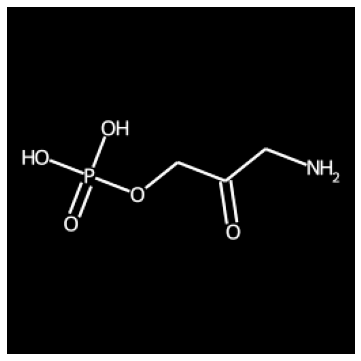

In [5]:
import os
import rapidjson
import cv2
from sklearn.model_selection import train_test_split

def create_filename(num: int) -> str:
    return str(num) + '.png'

FOLDER_NAME = 'images'
OUTPUT_FILENAME = 'num_of_images.json'

with open(OUTPUT_FILENAME, 'r') as json_file:
    data = rapidjson.load(json_file)

print('FINISH DOWNLOADING JSON')

smiles_number = 10000

max_len = max([len(datum['deepsmiles']) for datum in data])
pictures = []
smileses = []
cnt = 0
for datum in data:
    img = cv2.imread(
        os.path.join(FOLDER_NAME, create_filename(datum['image_num'])),
        cv2.IMREAD_GRAYSCALE
    )
    img = img.astype('float32')
    img /= 255
    pictures.append(img)
    #smileses.append(smiles_to_array(datum['deepsmiles'], max_len))
    smileses.append([[1, 0] if d == 0 else [0, 1] for d in datum['fingerprint']])
    cnt += 1
    if cnt >= smiles_number:
        break
pictures = np.expand_dims(np.array(pictures), axis=3)
smileses = np.array(smileses)
#print(f'SMILES_CHAR size = {len(SMILES_CHAR)}')
print(pictures.shape)
print(smileses.shape)
print(pictures[3].shape)
plt.figure(figsize=np.array(pictures[0].shape[:-1]) / 50)
plt.imshow(pictures[2], cmap='Greys')
plt.axis('off')
plt.tight_layout()
plt.show()
p_train, p_test, s_train, s_test = train_test_split(pictures, smileses, test_size=0.2)

In [1]:
input_shape = (256,256,1)
output_shape = (1024, 2)
pool_size = (2, 2)
conv_filters1 = 126
conv_filters2 = 20
conv_kernel = 3
print(output_shape)

(1024, 2)


In [2]:
model = Sequential(name='CnnToSmiles')

model.add(Input(shape=(256,256,1)))
model.add(Conv2D(filters=conv_filters1, kernel_size=conv_kernel, strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Conv2D(filters=conv_filters2, kernel_size=conv_kernel, strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_groups), activation='softmax'))

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [8]:
history = model.fit(p_train, s_train, 
          batch_size=32, epochs=20)

Epoch 1/20
250/250 [==============================] - 610s 2s/step - loss: 0.1177 - accuracy: 0.9755
Epoch 2/20
250/250 [==============================] - 598s 2s/step - loss: 0.0871 - accuracy: 0.9799
Epoch 3/20
250/250 [==============================] - 594s 2s/step - loss: 0.0810 - accuracy: 0.9807
Epoch 4/20
250/250 [==============================] - 593s 2s/step - loss: 0.0761 - accuracy: 0.9810
Epoch 5/20
250/250 [==============================] - 597s 2s/step - loss: 0.0710 - accuracy: 0.9811
Epoch 6/20
250/250 [==============================] - 597s 2s/step - loss: 0.0670 - accuracy: 0.9816
Epoch 7/20
250/250 [==============================] - 593s 2s/step - loss: 0.0639 - accuracy: 0.9820
Epoch 8/20
250/250 [==============================] - 590s 2s/step - loss: 0.0602 - accuracy: 0.9823
Epoch 9/20
250/250 [==============================] - 587s 2s/step - loss: 0.0556 - accuracy: 0.9827
Epoch 10/20
250/250 [==============================] - 591s 2s/step - loss: 0.0502 - accura

In [ ]:
model.save('cnn2')

In [9]:
model.evaluate(p_test, s_test)

63/63 [==============================] - 30s 461ms/step - loss: 0.0967 - accuracy: 0.9834


[0.09673476219177246, 0.9834428429603577]

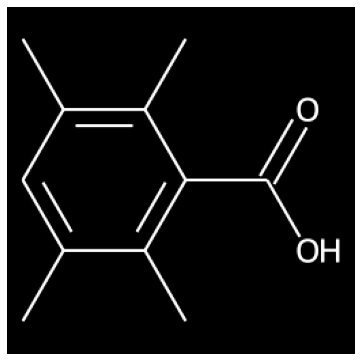

accuracy: 0.0


'\nsmiles_array = model.predict(np.array([p_test[ind]]))\nprint(smiles_array.shape)\nprint(array_to_smiles(smiles_array[0]))\nans = np.array(s_test[ind])\nprint(array_to_smiles(ans))\n'

In [11]:
def convert_to_01(array):
    res = []
    for elem in array:
        if elem[0] > elem[1]:
            res.append([1, 0])
        else:
            res.append([0, 1])
    return np.array(res)

ind = 8
plt.figure(figsize=np.array(p_test[ind].shape[:-1]) / 50)
plt.imshow(p_test[ind], cmap='Greys')
plt.axis('off')
plt.tight_layout()
plt.show()
trues = 0

for ind in range(1000):
    smiles_array = model.predict(np.array([p_test[ind]]))
    res_smiles = convert_to_01(smiles_array[0])
    if (s_test[ind] == res_smiles).all():
        trues += 1
    #print(s_test[ind])
    #print(res_smiles)
    #print((s_test[ind] == res_smiles).all())
print(f'accuracy: {trues / 1000}')

"""
smiles_array = model.predict(np.array([p_test[ind]]))
print(smiles_array.shape)
print(array_to_smiles(smiles_array[0]))
ans = np.array(s_test[ind])
print(array_to_smiles(ans))
"""

In [ ]:
kek_model = Model(inputs=model.input, outputs=model.layers[2].output)
kek_model.summary()

In [ ]:
p_size = 128
output_layout = kek_model.predict(np.array([p_test[ind]]))
print(output_layout[0, :, :, 0].reshape(p_size, p_size, -1).shape)
plt.imshow(output_layout[0, :, :, 1].reshape(p_size, p_size, -1), cmap='Greys')
plt.show()

In [ ]:
output_layout = kek_model.predict(np.array([p_test[ind]]))
all_layout_p = np.zeros((4 * p_size, 4 * p_size))
for i in range(4):
    for j in range(4):
        all_layout_p[i * p_size : (i + 1) * p_size, 
                     j * p_size : (j + 1) * p_size] = output_layout[0, :, :, 4 * i + j]
all_layout_p.reshape(4 * p_size, 4 * p_size, -1)
plt.imshow(all_layout_p, cmap='Greys')
plt.show()

In [ ]:
model.save('my_model')


In [ ]:
new_model = load_model('my_model')

smiles_array_new = new_model.predict(np.array([p_test[ind]]))
print(array_to_smiles(smiles_array_new[0]))
ans_new = np.array(s_test[ind])
print(array_to_smiles(ans_new))